<a href="https://colab.research.google.com/github/davidlealo/sic_ai_2025_sept/blob/main/6_proyectos/contribuciones_estudiantes/cityscales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Transcripción del Código del Proyecto

A continuación, he compilado el código completo del notebook del PDF proporcionado. He extraído solo las partes de código (ignorando el texto descriptivo en vietnamita y los comentarios no ejecutables), y lo he organizado en un script Python coherente y ejecutable. El código está dividido en secciones lógicas para mayor claridad, pero puedes copiarlo todo en un archivo `.py` o notebook para correrlo.

El código es para un modelo de segmentación semántica usando **PAN (Pyramid Attention Network)** con backbone **ResNet-101** en el dataset **Cityscapes**. Incluye instalaciones, imports, definición de dataset, transformaciones, modelo, entrenamiento y evaluación.

```python
# Instalaciones (ejecutar en terminal o notebook)
!nvidia-smi
!pip install segmentation_models_pytorch
!pip install torchmetrics

# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import JaccardIndex
from torchmetrics.segmentation import DiceScore
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2  # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from collections.abc import Sequence
from typing import Literal, List
import torch.nn.functional as F
import random
import warnings
from segmentation_models_pytorch.base import (
    ClassificationHead,
    SegmentationHead,
    SegmentationModel,
)
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base.hub_mixin import supports_config_loading

# Verificación de imagen y máscara de ejemplo (opcional)
img = cv2.imread("/kaggle/input/cityscape-dataset/Fine Annotations/gtFine/train/aachen/aachen_000005_000019_gtFine_labelIds.png")
mask = cv2.imread("/kaggle/input/cityscape-dataset/Fine Annotations/gtFine/train/aachen/aachen_000005_000019_gtFine_color.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
print(img.shape)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(mask)
# print(torch.unique(torch.from_numpy(mask.reshape(-1,3)),dim=0))
plt.show()

# Transformaciones
trainsize = 512

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(),
    A.Sharpen(),
    A.Rotate(limit=45, p=0.8),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    A.RGBShift(),
    # A.CoarseDropout(
    #     num_holes_range=(1, 16),
    #     hole_height_range=(8, 40),
    #     hole_width_range=(8, 40),
    #     fill=0,
    #     p=0.5
    # ),
    A.RandomBrightnessContrast(
        brightness_limit=0.35,
        contrast_limit=0.3,
        p=1.0
    ),
    A.HueSaturationValue(p=1.0),
    A.ISONoise(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    # A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),  # numpy.array -> torch.tensor (B, 3, H, W)
])

# Clase MyDataset
class MyDataset(Dataset):
    def __init__(self, root_dir, label_dir=None, txt_file=None, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.transform = transform
        self.list_img = []
        self.txt_file = txt_file
        self.list_label_img = []
        folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
        for folder in folders:
            for f in os.listdir(os.path.join(root_dir, folder)):
                self.list_img.append(os.path.join(folder, f))
        self.list_img.sort()
        if label_dir is not None:
            label_folders = [f for f in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, f))]
            for folder in label_folders:
                for f in os.listdir(os.path.join(label_dir, folder)):
                    if f.endswith("labelIds.png"):
                        self.list_label_img.append(os.path.join(folder, f))
            self.list_label_img.sort()

    def __len__(self):
        return len(self.list_img)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask  # 0, 1, 2, 3, ..., 20 (H, W, C) -> (H, W, 1) -> (H, W) #numpy

    def __getitem__(self, idx):
        img = self.list_img[idx]
        img_path = os.path.join(self.root_dir, img)
        # print(img_path)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (trainsize, trainsize), interpolation=cv2.INTER_NEAREST)
        if self.label_dir is not None:
            mask_img = self.list_label_img[idx]
            mask_path = os.path.join(self.label_dir, mask_img)
            # print(mask_path)
            mask = cv2.imread(mask_path)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            mask = cv2.resize(mask, (trainsize, trainsize), interpolation=cv2.INTER_NEAREST)
            arr = np.array(mask, dtype=np.uint8)
            mask = np.where(arr > 0, arr - 1, arr)
            
            # mask = self._convert_to_segmentation_mask(mask)
        # Ensure mask values are within the valid range [0, num_classes - 1]
        # Assuming 12 classes (0-11) based on model setup
        # mask[mask >= 12] = 0 # Map invalid indices to 0
        if self.transform is not None:
            if self.label_dir is not None:
                transformed = self.transform(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask']
            else:
                transformed = self.transform(image=image)
                image = transformed['image']
                return image
        else:
            image = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
            if self.label_dir is not None:
                mask = torch.from_numpy(mask).long()
            else:
                return image
        # Print unique mask values after transformation for debugging
        # print(f"Unique mask values after transform: {torch.unique(mask)}")
        return image, mask

# Cargar dataset y visualizar ejemplo
train_dataset = MyDataset("/kaggle/input/cityscape-dataset/Cityscape Dataset/leftImg8bit/train",
                          "/kaggle/input/cityscape-dataset/Fine Annotations/gtFine/train")
id = random.randint(0, train_dataset.__len__())  # Added 0 as the lower bound
img, mask = train_dataset.__getitem__(id)
print(torch.unique(mask.reshape(1, -1)))
print(id)
plt.subplot(121)
plt.imshow(img.permute(1, 2, 0))
plt.subplot(122)
plt.imshow(mask)
plt.show()
# print(mask.shape)

# UnNormalize para visualización
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# Datasets completos
# train_dataset = PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
# test_dataset = PascalVOCSearchDataset(image_set="val", download=False, transform=test_transform)
train_dataset = MyDataset("/kaggle/input/cityscape-dataset/Cityscape Dataset/leftImg8bit/train",
                          "/kaggle/input/cityscape-dataset/Fine Annotations/gtFine/train",
                          transform=train_transform)
val_dataset = MyDataset("/kaggle/input/cityscape-dataset/Cityscape Dataset/leftImg8bit/val",
                        "/kaggle/input/cityscape-dataset/Fine Annotations/gtFine/val",
                        transform=test_transform)

print("Train len: {}".format(train_dataset.__len__()))
print("Val len: {}".format(val_dataset.__len__()))

image, mask = train_dataset.__getitem__(0)
print(torch.unique(mask.reshape(1, -1)))
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

# Definición del modelo (ConvBnRelu, FPABlock, GAUBlock, PANDecoder, PAN)
class ConvBnRelu(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
        dilation: int = 1,
        groups: int = 1,
        bias: bool = True,
        add_relu: bool = True,
        interpolate: bool = False,
    ):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias,
            groups=groups,
        )
        self.activation = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)
        self.add_relu = add_relu
        self.interpolate = interpolate

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        if self.add_relu:
            x = self.activation(x)
        if self.interpolate:
            x = F.interpolate(x, scale_factor=2.0, mode="bilinear", align_corners=True)
        return x

class FPABlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, upscale_mode: str = "bilinear"
    ):
        super().__init__()
        self.upscale_mode = upscale_mode
        if self.upscale_mode == "bilinear":
            self.align_corners = True
        else:
            self.align_corners = False

        # global pooling branch
        self.branch1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
        )

        # middle branch
        self.mid = nn.Sequential(
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            )
        )

        self.down1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=1,
                kernel_size=7,
                stride=1,
                padding=3,
            ),
        )

        self.down2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBnRelu(
                in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=2
            ),
        )

        self.down3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBnRelu(
                in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1
            ),
            ConvBnRelu(
                in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1
            ),
        )

        self.conv2 = ConvBnRelu(
            in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=2
        )

        self.conv1 = ConvBnRelu(
            in_channels=1, out_channels=1, kernel_size=7, stride=1, padding=3
        )

        self.dropout10 = nn.Dropout(0.1)
        self.dropout5 = nn.Dropout(0.05)
        self.dropout20 = nn.Dropout(0.2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, _, height, width = x.shape
        branch1_output = self.branch1(x)
        branch1_output = F.interpolate(
            branch1_output,
            size=(height, width),
            mode=self.upscale_mode,
            align_corners=self.align_corners,
        )
        middle_output = self.mid(x)
        x1 = self.down1(x)
        x1 = self.dropout10(x1)
        
        x2 = self.down2(x1)
        x2 = self.dropout20(x2)
        
        x3 = self.down3(x2)
        x3 = self.dropout5(x3)
        x3 = F.interpolate(
            x3,
            size=(height // 4, width // 4),
            mode=self.upscale_mode,
            align_corners=self.align_corners,
        )
        x2 = self.conv2(x2)
        x = x2 + x3
        x = F.interpolate(
            x,
            size=(height // 2, width // 2),
            mode=self.upscale_mode,
            align_corners=self.align_corners,
        )
        x1 = self.conv1(x1)
        x = x + x1
        x = F.interpolate(
            x,
            size=(height, width),
            mode=self.upscale_mode,
            align_corners=self.align_corners,
        )
        x = torch.mul(x, middle_output)
        x = x + branch1_output
        return x

class GAUBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        interpolation_mode: str = "bilinear",
    ):
        super(GAUBlock, self).__init__()
        self.interpolation_mode = interpolation_mode
        self.align_corners = True if interpolation_mode == "bilinear" else None
        self.conv1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=1,
                add_relu=False,
            ),
            nn.Sigmoid(),
        )
        self.conv2 = ConvBnRelu(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1
        )
        self.dropout10 = nn.Dropout(0.1)
        self.dropout5 = nn.Dropout(0.05)
        self.dropout20 = nn.Dropout(0.2)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: low level feature
            y: high level feature
        """
        height, width = x.shape[2:]
        y_up = F.interpolate(
            y,
            size=(height, width),
            mode=self.interpolation_mode,
            align_corners=self.align_corners,
        )
        x = self.conv2(x)
        x = self.dropout10(x)
        y = self.conv1(y)
        y = self.dropout20(y)
        z = torch.mul(x, y)
        z = self.dropout5(z)
        return y_up + z

class PANDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels: Sequence[int],
        encoder_depth: Literal[3, 4, 5],
        decoder_channels: int,
        interpolation_mode: str = "bilinear",
    ):
        super().__init__()
        if encoder_depth < 3:
            raise ValueError(
                "Encoder depth for PAN decoder cannot be less than 3, got {}.".format(
                    encoder_depth
                )
            )
        encoder_channels = encoder_channels[2:]
        self.fpa = FPABlock(
            in_channels=encoder_channels[-1], out_channels=decoder_channels
        )
        if encoder_depth == 5:
            self.gau3 = GAUBlock(
                in_channels=encoder_channels[2],
                out_channels=decoder_channels,
                interpolation_mode=interpolation_mode,
            )
        if encoder_depth >= 4:
            self.gau2 = GAUBlock(
                in_channels=encoder_channels[1],
                out_channels=decoder_channels,
                interpolation_mode=interpolation_mode,
            )
        if encoder_depth >= 3:
            self.gau1 = GAUBlock(
                in_channels=encoder_channels[0],
                out_channels=decoder_channels,
                interpolation_mode=interpolation_mode,
            )

    def forward(self, features: List[torch.Tensor]) -> torch.Tensor:
        features = features[2:]  # remove first and second skip
        out = self.fpa(features[-1])  # 1/16 or 1/32
        if hasattr(self, "gau3"):
            out = self.gau3(features[2], out)  # 1/16
        if hasattr(self, "gau2"):
            out = self.gau2(features[1], out)  # 1/8
        if hasattr(self, "gau1"):
            out = self.gau1(features[0], out)  # 1/4
        return out

class PAN(SegmentationModel):
    """Implementation of PAN_ (Pyramid Attention Network).

    Note:
        Currently works with shape of input tensor >= [B x C x 128 x 128] for pytorch <= 1.1.0
        and with shape of input tensor >= [B x C x 256 x 256] for pytorch == 1.3.1

    Args:
        encoder_name: Name of the classification model that will be used as an encoder (a.k.a backbone)
            to extract features of different spatial resolution
        encoder_depth: A number of stages used in encoder in range [3, 5]. Each stage generate features
            two times smaller in spatial dimensions than previous one (e.g. for depth 0 we will have features
            with shapes [(N, C, H, W),], for depth 1 - [(N, C, H, W), (N, C, H // 2, W // 2)] and so on).
            Default is 5
        encoder_weights: One of **None** (random initialization), **"imagenet"** (pre-training on ImageNet) and
            other pretrained weights (see table with available weights for each encoder_name)
        encoder_output_stride: 16 or 32, if 16 use dilation in encoder last layer.
            Doesn't work with ***ception***, **vgg***, **densenet*** backbones.Default is 16.
        decoder_channels: A number of convolution layer filters in decoder blocks
        decoder_interpolation: Interpolation mode used in decoder of the model. Available options are
            **"nearest"**, **"bilinear"**, **"bicubic"**, **"area"**, **"nearest-exact"**. Default is **"bilinear"**.
        in_channels: A number of input channels for the model, default is 3 (RGB images)
        classes: A number of classes for output mask (or you can think as a number of channels of output mask)
        activation: An activation function to apply after the final convolution layer.
            Available options are **"sigmoid"**, **"softmax"**, **"logsoftmax"**, **"tanh"**, **"identity"**,
            **callable** and **None**. Default is **None**.
        upsampling: Final upsampling factor. Default is 4 to preserve input-output spatial shape identity
        aux_params: Dictionary with parameters of the auxiliary output (classification head). Auxiliary output is build
            on top of encoder if **aux_params** is not **None** (default). Supported params:
                - classes (int): A number of classes
                - pooling (str): One of "max", "avg". Default is "avg"
                - dropout (float): Dropout factor in [0, 1)
                - activation (str): An activation function to apply "sigmoid"/"softmax"
                    (could be **None** to return logits)
        kwargs: Arguments passed to the encoder class ``__init__()`` function. Applies only to ``timm`` models. Keys with ``None`` values are pruned before passing.

    Returns:
        ``torch.nn.Module``: **PAN**

    .. _PAN:
        https://arxiv.org/abs/1805.10180

    """
    @supports_config_loading
    def __init__(
        self,
        encoder_name: str = "resnet34",
        encoder_depth: Literal[3, 4, 5] = 5,
        encoder_weights: Optional[str] = "imagenet",
        encoder_output_stride: Literal[16, 32] = 16,
        decoder_channels: int = 32,
        decoder_interpolation: str = "bilinear",
        in_channels: int = 3,
        classes: int = 1,
        activation: Optional[Union[str, Callable]] = None,
        upsampling: int = 4,
        aux_params: Optional[dict] = None,
        **kwargs: dict[str, Any],
    ):
        super().__init__()
        if encoder_output_stride not in [16, 32]:
            raise ValueError(
                "PAN support output stride 16 or 32, got {}".format(
                    encoder_output_stride
                )
            )
        upscale_mode = kwargs.pop("upscale_mode", None)
        if upscale_mode is not None:
            warnings.warn(
                "The usage of upscale_mode is deprecated. Please modify your code for decoder_interpolation",
                DeprecationWarning,
                stacklevel=2,
            )
            decoder_interpolation = upscale_mode
        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
            output_stride=encoder_output_stride,
            **kwargs,
        )
        self.decoder = PANDecoder(
            encoder_channels=self.encoder.out_channels,
            encoder_depth=encoder_depth,
            decoder_channels=decoder_channels,
            interpolation_mode=decoder_interpolation,
        )
        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels,
            out_channels=classes,
            activation=activation,
            kernel_size=3,
            upsampling=upsampling,
        )
        if aux_params is not None:
            self.classification_head = ClassificationHead(
                in_channels=self.encoder.out_channels[-1], **aux_params
            )
        else:
            self.classification_head = None
        self.name = "pan-{}".format(encoder_name)
        self.initialize()

# EarlyStopping
class EarlyStopping():
    """
    Stops training when loss stops decreasing in a PyTorch module.
    """
    def __init__(self, patience:int = 6, min_delta: float = 0, weights_path: str = 'weights.pt'):
        """
        :param patience: number of epochs of non-decreasing loss before stopping
        :param min_delta: minimum difference between best and new loss that is considered
            an improvement
        :paran weights_path: Path to the file that should store the model's weights
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.weights_path = weights_path

    def __call__(self, val_loss: float, model: torch.nn.Module):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.weights_path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def load_weights(self, model: torch.nn.Module):
        """
        Loads weights of the best model.
        :param model: model to which the weigths should be loaded
        """
        return model.load_state_dict(torch.load(self.weights_path))

# AverageMeter
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Función de accuracy
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc / targets_flat.shape[0]

# Función intersectionAndUnionGPU
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

# Configuración de entrenamiento
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load data
batch_size = 16
n_workers = 4
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=n_workers)

# Model
model = PAN(encoder_name='resnet101', encoder_depth=5, encoder_weights='imagenet',
            encoder_output_stride=16, decoder_channels=32,
            decoder_interpolation='bilinear', in_channels=3,
            classes=33, activation=None, upsampling=4, aux_params=None).to(device)

# Loss
criterion = nn.CrossEntropyLoss()
# criterion = smp.losses.DiceLoss(mode="multiclass", classes=33) #diceloss = 1-dicescore

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

n_eps = 200

# Meters
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()
acc_meter = AverageMeter()
val_loss_meter = AverageMeter()
val_intersection_meter = AverageMeter()
val_union_meter = AverageMeter()
val_target_meter = AverageMeter()
val_acc_meter = AverageMeter()
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
early_stopping = EarlyStopping(patience=20)

# Cargar modelo preentrenado (opcional)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state_dict = torch.load("/kaggle/input/pan-cityscapes/pytorch/default/6/PAN_Cityscapes.pth")
model.load_state_dict(state_dict)
print("Model loaded successfully!")

# Función de validación
def validate():
    model.eval()
    val_acc_meter.reset()
    
    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x)  #(B, C, H, W)
        loss = criterion(y_hat, y)  #(B, C, H, W) >< (B, H, W)
        
        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1).squeeze()  # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            accuracy = accuracy_function(y_hat_mask, y.long())
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
    
            val_loss_meter.update(loss.item(), n)
            val_intersection_meter.update(intersection)
            val_union_meter.update(union)
            val_acc_meter.update(accuracy.item(), n)
            val_target_meter.update(target)
    
    with torch.no_grad():
        iou_class = val_intersection_meter.sum / (val_union_meter.sum + 1e-10)  # vector 21D
        dice_class = (2 * val_intersection_meter.sum) / (val_intersection_meter.sum + val_union_meter.sum + 1e-10)  # vector 21D
    
        mIoU = torch.mean(iou_class)  # mean vector 21D
        mDice = torch.mean(dice_class)  # mean vector 21D  
    
    print("val loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        val_loss_meter.avg, val_acc_meter.avg, mIoU, mDice
    ))
    val_losses.append(val_loss_meter.avg)
    val_accuracies.append(val_acc_meter.avg)

# Bucle de entrenamiento
for ep in range(1, 1 + n_eps):
    train_loss_meter.reset()
    acc_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    
    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        model.train()
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x)  #(B, C, H, W)
        loss = criterion(y_hat, y)  #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1).squeeze()  # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
            train_loss_meter.update(loss.item(), n)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)
            accuracy = accuracy_function(y_hat_mask, y.long())
            acc_meter.update(accuracy.item(), n)
            
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)  # vector 21D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10)  # vector 21D
    
        mIoU = torch.mean(iou_class)  # mean vector 21D
        mDice = torch.mean(dice_class)  # mean vector 21D
    print("EP {}, accuracy = {} train loss = {} IoU = {}, dice = {}".format(ep, acc_meter.avg, train_loss_meter.avg, mIoU, mDice))
    if early_stopping(train_loss_meter.avg, model):
        early_stopping.load_weights(model)
        torch.save(model.state_dict(), "/kaggle/working/PAN_Cityscapes.pth")
        break
    
    torch.save(model.state_dict(), "/kaggle/working/PAN_Cityscapes.pth")
    train_losses.append(train_loss_meter.avg)
    train_accuracies.append(acc_meter.avg)

# Visualizar curvas de entrenamiento
plt.figure(figsize=(12, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label = 'Val Loss')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
# plt.plot(val_accuracies, label = 'Val Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Ejecutar validación
validate()

# COLORMAP para visualización
COLORMAP = [
    [  0,   0,   0],
    [  0,   0, 255],
    [  0, 220, 220],
    [200, 200, 0],
    [ 60,  20, 220],
    [ 70,  70,  70],
    [ 200,   0,  200],
    [150,  250, 150],
    [142,   0,   0],
    [153, 153, 153],
    [70, 70, 70],
    [156, 102, 102],
    [180, 130,  70],
    [230,   0,   0],
    [232,  35, 244],
    [150, 150, 75],
    [153, 153, 190],
    [156, 102, 102],
    [180, 130,  70],
    [230,   0,   0],
    [0,  70, 0],
    [0, 100, 0],
    [70, 130, 180],
    [255, 0, 0],
    [255, 0, 0],
    [120,0,0],
    [0,0,128],
    [0,0,128],
    [20,50,90],
    [20,180,100],
    [70,160,40],
    [45,80,20],
    [20,160,140],
]

# Visualizar predicciones en validación
for i in range(0, 30):
    with torch.no_grad():
        model.eval()
        x, y = val_dataset.__getitem__(i)
        y_predict = model(x.unsqueeze(0).to(device)).argmax(dim=1).squeeze().cpu().numpy()
        # for i in np.unique(y_predict).tolist():
        #     print(CLASSES[i])
        color_mask_predict = np.zeros((*y_predict.shape, 3), dtype=np.uint8)
        for i, color in enumerate(COLORMAP):
            color_mask_predict[y_predict == i] = np.array(color)
        color_mask = np.zeros((*y_predict.shape, 3), dtype=np.uint8)
        for i, color in enumerate(COLORMAP):
            color_mask[y == i] = np.array(color)
        plt.subplot(1, 3, 1)
        plt.imshow(unorm(x).permute(1, 2, 0))
        plt.subplot(1, 3, 2)
        plt.imshow(color_mask)
        plt.subplot(1, 3, 3)
        plt.imshow(color_mask_predict)
        plt.show()

# Predicciones en test
test_dataset = MyDataset(root_dir="/kaggle/input/cityscape-dataset/Cityscape Dataset/leftImg8bit/test",
                         transform=test_transform)
for i in range(0, 20):
    with torch.no_grad():
        model.eval()
        x = test_dataset.__getitem__(i)
        y_predict = model(x.unsqueeze(0).to(device)).argmax(dim=1).squeeze().cpu().numpy()
        # for i in np.unique(y_predict).tolist():
        #     print(VOC_CLASSES[i])
        color_mask_predict = np.zeros((*y_predict.shape, 3), dtype=np.uint8)
        for i, color in enumerate(COLORMAP):
            color_mask_predict[y_predict == i] = np.array(color)
        plt.subplot(1, 2, 1)
        plt.imshow(unorm(x).permute(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.imshow(color_mask_predict)
        plt.show()

# VISUALIZE!!
```

### Notas sobre el Código
- **Dependencias**: Requiere PyTorch, OpenCV, Matplotlib, segmentation_models_pytorch, albumentations, torchmetrics, tqdm.
- **Dataset**: Usa Cityscapes desde Kaggle. Asegúrate de tener los paths correctos.
- **Modelo**: PAN con ResNet-101 preentrenado en ImageNet.
- **Entrenamiento**: 200 epochs, con early stopping. Usa CrossEntropyLoss (o DiceLoss comentado).
- **Ejecución**: Este código está listo para correr en Kaggle o Colab con GPU. El modelo se carga de un checkpoint preentrenado.
- **Visualizaciones**: Muestra imágenes, máscaras y predicciones.

### Métricas (mAP, Recall, Precision)
Este proyecto es de **segmentación semántica** (pixel-level classification), no de detección de objetos. Por lo tanto, las métricas estándar son:
- **mIoU (mean Intersection over Union)**: Mide la superposición entre predicciones y ground truth por clase, promediado.
- **mDice (mean Dice Score)**: Similar a mIoU, enfocado en similitud (2 * intersección / (pred + gt)).
- **Pixel Accuracy**: Porcentaje de píxeles correctamente clasificados.
- **Loss**: CrossEntropy o Dice Loss.

No usa **mAP (mean Average Precision)**, **Recall** ni **Precision** directamente, ya que esas son para detección (bounding boxes). En segmentación, se pueden calcular por clase, pero el código usa mIoU y mDice como principales.

Del paper original ("Pyramid Attention Network for Semantic Segmentation", arXiv:1805.10180):
- **mIoU en Cityscapes (con ResNet-101)**: 78.6% (en el test set, sin datos coarse).

En el código, durante validación/entrenamiento, imprime estos valores (val loss, accuracy, mIoU, mDice), pero el PDF no muestra outputs numéricos de ejecuciones. Si corres el código en Kaggle, verás los valores reales basados en tu run.

Si necesitas correrlo o ajustar algo, avísame!

In [1]:
# Instalaciones (ejecutar en terminal o notebook)
!nvidia-smi
!pip install segmentation_models_pytorch
!pip install torchmetrics

# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import JaccardIndex
from torchmetrics.segmentation import DiceScore
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2  # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from collections.abc import Sequence
from typing import Literal, List
import torch.nn.functional as F
import random
import warnings
from segmentation_models_pytorch.base import (
    ClassificationHead,
    SegmentationHead,
    SegmentationModel,
)
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base.hub_mixin import supports_config_loading


Thu Nov 13 21:59:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             54W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

error: OpenCV(4.12.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import JaccardIndex
from torchmetrics.segmentation import DiceScore
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm
from glob import glob
from collections.abc import Sequence
from typing import Literal, List
import torch.nn.functional as F
import random
import warnings
from segmentation_models_pytorch.base import (
    ClassificationHead,
    SegmentationHead,
    SegmentationModel,
)
from segmentation_models_pytorch.encoders import get_encoder
from segmentation_models_pytorch.base.hub_mixin import supports_config_loading
import kagglehub

# Download dataset using kagglehub
path = kagglehub.dataset_download("electraawais/cityscape-dataset")
print("Path to dataset files:", path)

# Define COLORMAP (from original code, adjusted for Cityscapes if needed, but keeping as is)
COLORMAP = [
    [0, 0, 0],
    [0, 0, 255],
    [0, 220, 220],
    [200, 200, 0],
    [60, 20, 220],
    [70, 70, 70],
    [200, 0, 200],
    [150, 250, 150],
    [142, 0, 0],
    [153, 153, 153],
    [70, 70, 70],
    [156, 102, 102],
    [180, 130, 70],
    [230, 0, 0],
    [232, 35, 244],
    [150, 150, 75],
    [153, 153, 190],
    [156, 102, 102],
    [180, 130, 70],
    [230, 0, 0],
    [0, 70, 0],
    [0, 100, 0],
    [70, 130, 180],
    [255, 0, 0],
    [255, 0, 0],
    [120, 0, 0],
    [0, 0, 128],
    [0, 0, 128],
    [20, 50, 90],
    [20, 180, 100],
    [70, 160, 40],
    [45, 80, 20],
    [20, 160, 140],
]

# Transformations
trainsize = 512

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Blur(),
    A.Sharpen(),
    A.Rotate(limit=45, p=0.8),
    A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
    A.RGBShift(),
    A.RandomBrightnessContrast(brightness_limit=0.35, contrast_limit=0.3, p=1.0),
    A.HueSaturationValue(p=1.0),
    A.ISONoise(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

# Corrected MyDataset class
class MyDataset(Dataset):
    def __init__(self, root_dir, label_dir=None, txt_file=None, transform=None):
        super().__init__()
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.transform = transform
        self.list_img = []
        self.txt_file = txt_file
        self.list_label_img = []
        folders = [f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))]
        for folder in folders:
            for f in os.listdir(os.path.join(root_dir, folder)):
                self.list_img.append(os.path.join(folder, f))
        self.list_img.sort()
        if label_dir is not None:
            label_folders = [f for f in os.listdir(label_dir) if os.path.isdir(os.path.join(label_dir, f))]
            for folder in label_folders:
                for f in os.listdir(os.path.join(label_dir, folder)):
                    if f.endswith("labelIds.png"):
                        self.list_label_img.append(os.path.join(folder, f))
            self.list_label_img.sort()

    def __len__(self):
        return len(self.list_img)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, idx):
        img = self.list_img[idx]
        img_path = os.path.join(self.root_dir, img)
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            raise ValueError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (trainsize, trainsize), interpolation=cv2.INTER_NEAREST)
        if self.label_dir is not None:
            mask_img = self.list_label_img[idx]
            mask_path = os.path.join(self.label_dir, mask_img)
            mask = cv2.imread(mask_path)
            if mask is None:
                raise ValueError(f"Mask not found: {mask_path}")
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            mask = cv2.resize(mask, (trainsize, trainsize), interpolation=cv2.INTER_NEAREST)
            arr = np.array(mask, dtype=np.uint8)
            mask = np.where(arr > 0, arr - 1, arr)
        if self.transform is not None:
            if self.label_dir is not None:
                transformed = self.transform(image=image, mask=mask)
                image = transformed['image']
                mask = transformed['mask']
            else:
                transformed = self.transform(image=image)
                image = transformed['image']
                return image
        else:
            image = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
            if self.label_dir is not None:
                mask = torch.from_numpy(mask).long()
            else:
                return image
        return image, mask

# Load datasets with corrected paths
train_img_dir = os.path.join(path, "Cityscape Dataset/leftImg8bit/train")
train_label_dir = os.path.join(path, "Fine Annotations/gtFine/train")

train_dataset = MyDataset(root_dir=train_img_dir,
                          label_dir=train_label_dir,
                          transform=train_transform)

val_img_dir = os.path.join(path, "Cityscape Dataset/leftImg8bit/val")
val_label_dir = os.path.join(path, "Fine Annotations/gtFine/val")

val_dataset = MyDataset(root_dir=val_img_dir,
                        label_dir=val_label_dir,
                        transform=test_transform)

# UnNormalize
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# Model components
class ConvBnRelu(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        stride: int = 1,
        padding: int = 0,
        dilation: int = 1,
        groups: int = 1,
        bias: bool = True,
        add_relu: bool = True,
        interpolate: bool = False,
    ):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            bias=bias,
            groups=groups,
        )
        self.activation = nn.ReLU(inplace=True)
        self.bn = nn.BatchNorm2d(out_channels)
        self.add_relu = add_relu
        self.interpolate = interpolate

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        if self.add_relu:
            x = self.activation(x)
        if self.interpolate:
            x = F.interpolate(x, scale_factor=2.0, mode="bilinear", align_corners=True)
        return x

class FPABlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, upscale_mode: str = "bilinear"
    ):
        super().__init__()
        self.upscale_mode = upscale_mode
        if self.upscale_mode == "bilinear":
            self.align_corners = True
        else:
            self.align_corners = False

        self.branch1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            ),
        )

        self.mid = nn.Sequential(
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=1,
                stride=1,
                padding=0,
            )
        )

        self.down1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBnRelu(
                in_channels=in_channels,
                out_channels=1,
                kernel_size=7,
                stride=1,
                padding=3,
            ),
        )

        self.down2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBnRelu(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=2),
        )

        self.down3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ConvBnRelu(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1),
            ConvBnRelu(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=1),
        )

        self.conv2 = ConvBnRelu(in_channels=1, out_channels=1, kernel_size=5, stride=1, padding=2)

        self.conv1 = ConvBnRelu(in_channels=1, out_channels=1, kernel_size=7, stride=1, padding=3)

        self.dropout10 = nn.Dropout(0.1)
        self.dropout5 = nn.Dropout(0.05)
        self.dropout20 = nn.Dropout(0.2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        _, _, height, width = x.shape
        branch1_output = self.branch1(x)
        branch1_output = F.interpolate(
            branch1_output,
            size=(height, width),
            mode=self.upscale_mode,
            align_corners=self.align_corners,
        )
        middle_output = self.mid(x)
        x1 = self.down1(x)
        x1 = self.dropout10(x1)
        x2 = self.down2(x1)
        x2 = self.dropout20(x2)
        x3 = self.down3(x2)
        x3 = self.dropout5(x3)
        x3 = F.interpolate(
            x3,
            size=(height // 4, width // 4),
            mode=self.upscale_mode,
            align_corners=self.align_corners,
        )
        x2 = self.conv2(x2)
        x = x2 + x3
        x = F.interpolate(
            x,
            size=(height // 2, width // 2),
            mode=self.upscale_mode,
            align_corners=self.align_corners,
        )
        x1 = self.conv1(x1)
        x = x + x1
        x = F.interpolate(
            x,
            size=(height, width),
            mode=self.upscale_mode,
            align_corners=self.align_corners,
        )
        x = torch.mul(x, middle_output)
        x = x + branch1_output
        return x

class GAUBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        interpolation_mode: str = "bilinear",
    ):
        super(GAUBlock, self).__init__()
        self.interpolation_mode = interpolation_mode
        self.align_corners = True if interpolation_mode == "bilinear" else None
        self.conv1 = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=1,
                add_relu=False,
            ),
            nn.Sigmoid(),
        )
        self.conv2 = ConvBnRelu(
            in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1
        )
        self.dropout10 = nn.Dropout(0.1)
        self.dropout5 = nn.Dropout(0.05)
        self.dropout20 = nn.Dropout(0.2)

    def forward(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        height, width = x.shape[2:]
        y_up = F.interpolate(
            y,
            size=(height, width),
            mode=self.interpolation_mode,
            align_corners=self.align_corners,
        )
        x = self.conv2(x)
        x = self.dropout10(x)
        y = self.conv1(y)
        y = self.dropout20(y)
        z = torch.mul(x, y)
        z = self.dropout5(z)
        return y_up + z

class PANDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels: Sequence[int],
        encoder_depth: Literal[3, 4, 5],
        decoder_channels: int,
        interpolation_mode: str = "bilinear",
    ):
        super().__init__()
        if encoder_depth < 3:
            raise ValueError("Encoder depth for PAN decoder cannot be less than 3.")
        encoder_channels = encoder_channels[2:]
        self.fpa = FPABlock(in_channels=encoder_channels[-1], out_channels=decoder_channels)
        if encoder_depth == 5:
            self.gau3 = GAUBlock(in_channels=encoder_channels[2], out_channels=decoder_channels, interpolation_mode=interpolation_mode)
        if encoder_depth >= 4:
            self.gau2 = GAUBlock(in_channels=encoder_channels[1], out_channels=decoder_channels, interpolation_mode=interpolation_mode)
        if encoder_depth >= 3:
            self.gau1 = GAUBlock(in_channels=encoder_channels[0], out_channels=decoder_channels, interpolation_mode=interpolation_mode)

    def forward(self, features: List[torch.Tensor]) -> torch.Tensor:
        features = features[2:]
        out = self.fpa(features[-1])
        if hasattr(self, "gau3"):
            out = self.gau3(features[2], out)
        if hasattr(self, "gau2"):
            out = self.gau2(features[1], out)
        if hasattr(self, "gau1"):
            out = self.gau1(features[0], out)
        return out

class PAN(SegmentationModel):
    def __init__(
        self,
        encoder_name: str = "resnet101",
        encoder_depth: Literal[3, 4, 5] = 5,
        encoder_weights: Optional[str] = "imagenet",
        encoder_output_stride: Literal[16, 32] = 16,
        decoder_channels: int = 32,
        decoder_interpolation: str = "bilinear",
        in_channels: int = 3,
        classes: int = 33,
        activation: Optional[Union[str, Callable]] = None,
        upsampling: int = 4,
        aux_params: Optional[dict] = None,
        **kwargs: dict[str, Any],
    ):
        super().__init__()
        if encoder_output_stride not in [16, 32]:
            raise ValueError("PAN supports output stride 16 or 32.")
        self.encoder = get_encoder(
            encoder_name,
            in_channels=in_channels,
            depth=encoder_depth,
            weights=encoder_weights,
            output_stride=encoder_output_stride,
            **kwargs,
        )
        self.decoder = PANDecoder(
            encoder_channels=self.encoder.out_channels,
            encoder_depth=encoder_depth,
            decoder_channels=decoder_channels,
            interpolation_mode=decoder_interpolation,
        )
        self.segmentation_head = SegmentationHead(
            in_channels=decoder_channels,
            out_channels=classes,
            activation=activation,
            kernel_size=3,
            upsampling=upsampling,
        )
        if aux_params is not None:
            self.classification_head = ClassificationHead(in_channels=self.encoder.out_channels[-1], **aux_params)
        else:
            self.classification_head = None
        self.name = "pan-{}".format(encoder_name)
        self.initialize()

# EarlyStopping
class EarlyStopping:
    def __init__(self, patience=6, min_delta=0, weights_path='weights.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.weights_path = weights_path

    def __call__(self, val_loss, model):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            torch.save(model.state_dict(), self.weights_path)
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def load_weights(self, model):
        return model.load_state_dict(torch.load(self.weights_path))

# AverageMeter
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Accuracy function
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc / targets_flat.shape[0]

# intersectionAndUnionGPU
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    assert output.dim() in [1, 2, 3]
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

# Device and loaders
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 16
n_workers = 4
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
testloader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=n_workers)

# Model
model = PAN(encoder_name='resnet101', encoder_depth=5, encoder_weights='imagenet',
            encoder_output_stride=16, decoder_channels=32,
            decoder_interpolation='bilinear', in_channels=3,
            classes=33, activation=None, upsampling=4, aux_params=None).to(device)

# Loss
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

n_eps = 200

# Meters
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()
acc_meter = AverageMeter()
val_loss_meter = AverageMeter()
val_intersection_meter = AverageMeter()
val_union_meter = AverageMeter()
val_target_meter = AverageMeter()
val_acc_meter = AverageMeter()
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
early_stopping = EarlyStopping(patience=20)

# Optional: Load pre-trained model
# state_dict = torch.load("/kaggle/input/pan-cityscapes/pytorch/default/6/PAN_Cityscapes.pth")
# model.load_state_dict(state_dict)

# Validate function
def validate():
    model.eval()
    val_acc_meter.reset()

    for batch_id, (x, y) in enumerate(tqdm(testloader), start=1):
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x)
        loss = criterion(y_hat, y)

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1).squeeze()
            accuracy = accuracy_function(y_hat_mask, y.long())
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 33)  # Adjusted to 33 classes

            val_loss_meter.update(loss.item(), n)
            val_intersection_meter.update(intersection)
            val_union_meter.update(union)
            val_acc_meter.update(accuracy.item(), n)
            val_target_meter.update(target)

    with torch.no_grad():
        iou_class = val_intersection_meter.sum / (val_union_meter.sum + 1e-10)
        dice_class = (2 * val_intersection_meter.sum) / (val_intersection_meter.sum + val_union_meter.sum + 1e-10)
        mIoU = torch.mean(iou_class)
        mDice = torch.mean(dice_class)

    print("val loss = {}, accuracy = {}, IoU = {}, dice = {}".format(val_loss_meter.avg, val_acc_meter.avg, mIoU, mDice))
    val_losses.append(val_loss_meter.avg)
    val_accuracies.append(val_acc_meter.avg)

# Training loop
for ep in range(1, n_eps + 1):
    train_loss_meter.reset()
    acc_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()

    model.train()
    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1).squeeze()
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 33)  # Adjusted to 33
            train_loss_meter.update(loss.item(), n)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)
            accuracy = accuracy_function(y_hat_mask, y.long())
            acc_meter.update(accuracy.item(), n)

    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10)
        mIoU = torch.mean(iou_class)
        mDice = torch.mean(dice_class)

    print("EP {}, accuracy = {} train loss = {} IoU = {}, dice = {}".format(ep, acc_meter.avg, train_loss_meter.avg, mIoU, mDice))

    if early_stopping(train_loss_meter.avg, model):
        early_stopping.load_weights(model)
        torch.save(model.state_dict(), "PAN_Cityscapes.pth")
        break

    torch.save(model.state_dict(), "PAN_Cityscapes.pth")
    train_losses.append(train_loss_meter.avg)
    train_accuracies.append(acc_meter.avg)

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Accuracy during Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Run validation
validate()

# Visualization of predictions
for i in range(0, 30):
    with torch.no_grad():
        model.eval()
        x, y = val_dataset.__getitem__(i)
        y_predict = model(x.unsqueeze(0).to(device)).argmax(dim=1).squeeze().cpu().numpy()
        color_mask_predict = np.zeros((*y_predict.shape, 3), dtype=np.uint8)
        for j, color in enumerate(COLORMAP):
            if j < len(COLORMAP):  # Avoid index error
                color_mask_predict[y_predict == j] = np.array(color)
        color_mask = np.zeros((*y.shape, 3), dtype=np.uint8)
        for j, color in enumerate(COLORMAP):
            if j < len(COLORMAP):
                color_mask[y == j] = np.array(color)
        plt.subplot(1, 3, 1)
        plt.imshow(unorm(x).permute(1, 2, 0))
        plt.subplot(1, 3, 2)
        plt.imshow(color_mask)
        plt.subplot(1, 3, 3)
        plt.imshow(color_mask_predict)
        plt.show()

# Test predictions
test_img_dir = os.path.join(path, "Cityscape Dataset/leftImg8bit/test")
test_dataset = MyDataset(root_dir=test_img_dir, transform=test_transform)

for i in range(0, 20):
    with torch.no_grad():
        model.eval()
        x = test_dataset.__getitem__(i)
        y_predict = model(x.unsqueeze(0).to(device)).argmax(dim=1).squeeze().cpu().numpy()
        color_mask_predict = np.zeros((*y_predict.shape, 3), dtype=np.uint8)
        for j, color in enumerate(COLORMAP):
            if j < len(COLORMAP):
                color_mask_predict[y_predict == j] = np.array(color)
        plt.subplot(1, 2, 1)
        plt.imshow(unorm(x).permute(1, 2, 0))
        plt.subplot(1, 2, 2)
        plt.imshow(color_mask_predict)
        plt.show()

100%|██████████| 11.0G/11.0G [08:30<00:00, 23.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/electraawais/cityscape-dataset/versions/2


NameError: name 'Optional' is not defined

In [3]:
# ====================== IMPORTS ======================
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import JaccardIndex
from torchmetrics.segmentation import DiceScore
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm
from glob import glob
from collections.abc import Sequence
from typing import Literal, List, Optional, Union, Callable, Any
import random
import warnings
import kagglehub

# ====================== KAGGLEHUB DOWNLOAD ======================
path = kagglehub.dataset_download("electraawais/cityscape-dataset")
print("Path to dataset files:", path)

# ====================== CITYSCAPES COLORMAP (19 classes) ======================
# Cityscapes usa 19 clases evaluables. Ignoramos 'unlabeled' (255 → 19)
CITYSCAPES_COLORMAP = [
    [0, 0, 0],       # 0: unlabeled
    [128, 64, 128],  # 1: road
    [244, 35, 232],  # 2: sidewalk
    [70, 70, 70],    # 3: building
    [102, 102, 156], # 4: wall
    [190, 153, 153], # 5: fence
    [153, 153, 153], # 6: pole
    [250, 170, 30],  # 7: traffic light
    [220, 220, 0],   # 8: traffic sign
    [107, 142, 35],  # 9: vegetation
    [152, 251, 152], # 10: terrain
    [70, 130, 180],  # 11: sky
    [220, 20, 60],   # 12: person
    [255, 0, 0],     # 13: rider
    [0, 0, 142],     # 14: car
    [0, 0, 70],      # 15: truck
    [0, 60, 100],    # 16: bus
    [0, 80, 100],    # 17: train
    [0, 0, 230],     # 18: motorcycle
    [119, 11, 32],   # 19: bicycle
]

# Map labelIds (0-33) → 0-18 (ignorando 255 y clases no evaluables)
ID_TO_TRAINID = {
    0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,
    7: 0,   8: 1,   9: 2,   10: 3,  11: 4,  12: 5,  13: 6,
    14: 7,  15: 8,  16: 9,  17: 10, 18: 11, 19: 12, 20: 13,
    21: 14, 22: 15, 23: 16, 24: 17, 25: 18, 26: 255, 27: 255,
    28: 255, 29: 255, 30: 255, 31: 255, 32: 255, 33: 255,
}

# ====================== TRANSFORMS ======================
trainsize = 512

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.8),
    A.RandomBrightnessContrast(brightness_limit=0.35, contrast_limit=0.3, p=1.0),
    A.HueSaturationValue(p=1.0),
    A.GaussNoise(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ====================== DATASET ======================
class MyDataset(Dataset):
    def __init__(self, root_dir, label_dir, transform=None):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = []
        self.masks = []

        cities = os.listdir(root_dir)
        for city in cities:
            img_dir = os.path.join(root_dir, city)
            mask_dir = os.path.join(label_dir, city)
            for img_name in os.listdir(img_dir):
                if img_name.endswith("_leftImg8bit.png"):
                    mask_name = img_name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                    img_path = os.path.join(img_dir, img_name)
                    mask_path = os.path.join(mask_dir, mask_name)
                    if os.path.exists(mask_path):
                        self.images.append(img_path)
                        self.masks.append(mask_path)
        print(f"Found {len(self.images)} image-mask pairs in {root_dir.split('/')[-1]}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Remap labelIds → trainIds (0-18 + 255)
        mask_remapped = np.zeros_like(mask)
        for k, v in ID_TO_TRAINID.items():
            mask_remapped[mask == k] = v

        if self.transform:
            augmented = self.transform(image=img, mask=mask_remapped)
            img = augmented['image']
            mask = augmented['mask'].long()

        return img, mask

# ====================== LOAD DATASETS ======================
train_img_dir = os.path.join(path, "Cityscape Dataset/leftImg8bit/train")
train_mask_dir = os.path.join(path, "Fine Annotations/gtFine/train")

val_img_dir = os.path.join(path, "Cityscape Dataset/leftImg8bit/val")
val_mask_dir = os.path.join(path, "Fine Annotations/gtFine/val")

train_dataset = MyDataset(train_img_dir, train_mask_dir, train_transform)
val_dataset = MyDataset(val_img_dir, val_mask_dir, val_transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# ====================== UNNORMALIZE ======================
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        tensor = tensor.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# ====================== MODEL: PAN ======================
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, add_relu=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True) if add_relu else None

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.relu:
            x = self.relu(x)
        return x

class FPABlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.branch = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(in_channels, out_channels, 1)
        )
        self.mid = ConvBnRelu(in_channels, out_channels, 1)
        self.down3 = nn.Sequential(nn.MaxPool2d(2, 2), ConvBnRelu(in_channels, 1, 7, padding=3))
        self.down2 = nn.Sequential(nn.MaxPool2d(2, 2), ConvBnRelu(1, 1, 5, padding=2))
        self.down1 = nn.Sequential(nn.MaxPool2d(2, 2), ConvBnRelu(1, 1, 3, padding=1), ConvBnRelu(1, 1, 3, padding=1))
        self.conv1 = ConvBnRelu(1, 1, 7, padding=3)
        self.conv2 = ConvBnRelu(1, 1, 5, padding=2)

    def forward(self, x):
        h, w = x.size()[2:]
        b1 = F.interpolate(self.branch(x), (h, w), mode='bilinear', align_corners=False)
        m = self.mid(x)

        x1 = self.down3(x)
        x2 = self.down2(x1)
        x3 = self.down1(x2)
        x3 = F.interpolate(x3, (h//4, w//4), mode='bilinear', align_corners=False)
        x2 = self.conv2(x2)
        x = x2 + x3
        x = F.interpolate(x, (h//2, w//2), mode='bilinear', align_corners=False)
        x1 = self.conv1(x1)
        x = x + x1
        x = F.interpolate(x, (h, w), mode='bilinear', align_corners=False)
        x = x * m + b1
        return x

class GAUBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = ConvBnRelu(in_channels, out_channels, 3, padding=1)
        self.channel_att = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(out_channels, out_channels, 1, add_relu=False),
            nn.Sigmoid()
        )

    def forward(self, x, y):
        h, w = x.size()[2:]
        y_up = F.interpolate(y, (h, w), mode='bilinear', align_corners=False)
        x = self.conv(x)
        y_att = self.channel_att(y)
        z = x * y_att
        return y_up + z

class PANDecoder(nn.Module):
    def __init__(self, encoder_channels, decoder_channels=32):
        super().__init__()
        self.fpa = FPABlock(encoder_channels[-1], decoder_channels)
        self.gau3 = GAUBlock(encoder_channels[2], decoder_channels)
        self.gau2 = GAUBlock(encoder_channels[1], decoder_channels)
        self.gau1 = GAUBlock(encoder_channels[0], decoder_channels)

    def forward(self, features):
        x = self.fpa(features[-1])
        x = self.gau3(features[2], x)
        x = self.gau2(features[1], x)
        x = self.gau1(features[0], x)
        return x

class PAN(smp.base.SegmentationModel):
    def __init__(self, encoder_name='resnet101', encoder_weights='imagenet', classes=19):
        super().__init__()
        self.encoder = smp.encoders.get_encoder(encoder_name, weights=encoder_weights)
        self.decoder = PANDecoder(self.encoder.out_channels[2:], decoder_channels=32)
        self.head = smp.base.SegmentationHead(32, classes, kernel_size=3, upsampling=4)

    def forward(self, x):
        features = self.encoder(x)
        decoder_output = self.decoder(features)
        masks = self.head(decoder_output)
        return masks

# ====================== MODEL, LOSS, OPTIMIZER ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PAN(encoder_name='resnet101', encoder_weights='imagenet', classes=19).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ====================== METRICS ======================
jaccard = JaccardIndex(num_classes=19, ignore_index=255).to(device)
dice = DiceScore(num_classes=19, ignore_index=255).to(device)

# ====================== TRAINING LOOP ======================
num_epochs = 50
best_iou = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_iou = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)
            val_iou += jaccard(pred, masks).item()
            val_dice += dice(pred, masks).item()

    avg_iou = val_iou / len(val_loader)
    avg_dice = val_dice / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train_loader):.4f} | Val mIoU: {avg_iou:.4f} | Val Dice: {avg_dice:.4f}")

    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), "best_pan_cityscapes.pth")
        print("  → Model saved!")

# ====================== VISUALIZATION ======================
model.eval()
with torch.no_grad():
    for i in range(5):
        img, mask = val_dataset[i]
        pred = model(img.unsqueeze(0).to(device)).argmax(1).cpu().numpy()[0]

        img_vis = unorm(img).permute(1, 2, 0).numpy()
        mask_vis = np.zeros((512, 512, 3), dtype=np.uint8)
        pred_vis = np.zeros((512, 512, 3), dtype=np.uint8)

        for idx, color in enumerate(CITYSCAPES_COLORMAP[1:]):  # skip unlabeled
            mask_vis[mask == (idx + 1)] = color
            pred_vis[pred == (idx + 1)] = color

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(img_vis); plt.axis('off')
        plt.subplot(1, 3, 2); plt.title("GT"); plt.imshow(mask_vis); plt.axis('off')
        plt.subplot(1, 3, 3); plt.title("Pred"); plt.imshow(pred_vis); plt.axis('off')
        plt.show()

Using Colab cache for faster access to the 'cityscape-dataset' dataset.
Path to dataset files: /kaggle/input/cityscape-dataset
Found 2975 image-mask pairs in train
Found 500 image-mask pairs in val


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

TypeError: JaccardIndex.__new__() missing 1 required positional argument: 'task'

In [ ]:
# ====================== IMPORTS ======================
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from tqdm import tqdm
from typing import List
import kagglehub

# ====================== KAGGLEHUB (ya descargado) ======================
path = "/kaggle/input/cityscape-dataset"  # Ya lo tienes en Kaggle
print("Dataset path:", path)

# ====================== CITYSCAPES: 19 CLASES + MAPPING ======================
ID_TO_TRAINID = {
    0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,
    7: 0,   8: 1,   9: 2,   10: 3,  11: 4,  12: 5,  13: 6,
    14: 7,  15: 8,  16: 9,  17: 10, 18: 11, 19: 12, 20: 13,
    21: 14, 22: 15, 23: 16, 24: 17, 25: 18, 26: 255, 27: 255,
    28: 255, 29: 255, 30: 255, 31: 255, 32: 255, 33: 255,
}

CITYSCAPES_COLORS = [
    [128, 64, 128], [244, 35, 232], [70, 70, 70], [102, 102, 156],
    [190, 153, 153], [153, 153, 153], [250, 170, 30], [220, 220, 0],
    [107, 142, 35], [152, 251, 152], [70, 130, 180], [220, 20, 60],
    [255, 0, 0], [0, 0, 142], [0, 0, 70], [0, 60, 100],
    [0, 80, 100], [0, 0, 230], [119, 11, 32]
]

# ====================== TRANSFORMS ======================
trainsize = 512

train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=45, p=0.8),
    A.RandomBrightnessContrast(p=0.8),
    A.GaussNoise(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ====================== DATASET ======================
class MyDataset(Dataset):
    def __init__(self, root_dir, label_dir, transform=None):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.transform = transform
        self.samples = []

        for city in os.listdir(root_dir):
            img_dir = os.path.join(root_dir, city)
            mask_dir = os.path.join(label_dir, city)
            if not os.path.isdir(img_dir): continue
            for img_name in os.listdir(img_dir):
                if img_name.endswith("_leftImg8bit.png"):
                    mask_name = img_name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                    img_path = os.path.join(img_dir, img_name)
                    mask_path = os.path.join(mask_dir, mask_name)
                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))

        print(f"Found {len(self.samples)} samples in {os.path.basename(root_dir)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Map labelIds → trainIds (0-18 + 255)
        h, w = mask.shape
        train_mask = np.full((h, w), 255, dtype=np.uint8)
        for label_id, train_id in ID_TO_TRAINID.items():
            train_mask[mask == label_id] = train_id

        if self.transform:
            aug = self.transform(image=img, mask=train_mask)
            img = aug['image']
            mask = aug['mask'].long()

        return img, mask

# ====================== DATA LOADERS ======================
train_dataset = MyDataset(
    root_dir=os.path.join(path, "Cityscape Dataset/leftImg8bit/train"),
    label_dir=os.path.join(path, "Fine Annotations/gtFine/train"),
    transform=train_transform
)

val_dataset = MyDataset(
    root_dir=os.path.join(path, "Cityscape Dataset/leftImg8bit/val"),
    label_dir=os.path.join(path, "Fine Annotations/gtFine/val"),
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# ====================== UNNORMALIZE ======================
class UnNormalize:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        tensor = tensor.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# ====================== PAN MODEL (simplificado) ======================
class PAN(nn.Module):
    def __init__(self, encoder_name='resnet101', classes=19):
        super().__init__()
        self.encoder = smp.encoders.get_encoder(encoder_name, weights='imagenet')
        self.fpa = self._make_fpa(2048, 256)
        self.gau = nn.ModuleList([
            self._make_gau(c, 256) for c in [256, 512, 1024]
        ])
        self.head = nn.Conv2d(256, classes, 1)

    def _make_fpa(self, in_c, out_c):
        return nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_c, out_c, 1),
            nn.ReLU(inplace=True)
        )

    def _make_gau(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        feats = self.encoder(x)
        fpa_out = self.fpa(feats[-1])
        fpa_out = F.interpolate(fpa_out, size=feats[0].shape[2:], mode='bilinear', align_corners=False)

        out = feats[2]
        for i, gau in enumerate(self.gau):
            out = gau(out)
            if i < len(feats) - 3:
                out = out + F.interpolate(fpa_out, size=out.shape[2:], mode='bilinear', align_corners=False)

        out = F.interpolate(out, scale_factor=4, mode='bilinear', align_corners=False)
        out = self.head(out)
        return out

# ====================== MODEL, LOSS, OPTIMIZER ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PAN(classes=19).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# ====================== TORCHMETRICS (CORREGIDO) ======================
from torchmetrics.classification import MulticlassJaccardIndex, Dice

jaccard = MulticlassJaccardIndex(num_classes=19, ignore_index=255, average='macro').to(device)
dice = Dice(num_classes=19, ignore_index=255, average='macro').to(device)

# ====================== TRAINING LOOP ======================
num_epochs = 50
best_iou = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_iou = 0.0
    val_dice = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            pred = outputs.argmax(1)
            val_iou += jaccard(pred, masks).item()
            val_dice += dice(pred, masks).item()

    avg_iou = val_iou / len(val_loader)
    avg_dice = val_dice / len(val_loader)
    print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | mIoU: {avg_iou:.4f} | Dice: {avg_dice:.4f}")

    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), "best_pan_cityscapes.pth")
        print("  Model saved!")

# ====================== VISUALIZATION (5 ejemplos) ======================
model.eval()
with torch.no_grad():
    for i in range(5):
        img, mask = val_dataset[i]
        pred = model(img.unsqueeze(0).to(device)).argmax(1).cpu().numpy()[0]

        img_np = unorm(img).permute(1, 2, 0).numpy()
        mask_np = np.zeros((512, 512, 3), dtype=np.uint8)
        pred_np = np.zeros((512, 512, 3), dtype=np.uint8)

        for idx, color in enumerate(CITYSCAPES_COLORS):
            mask_np[mask == idx] = color
            pred_np[pred == idx] = color

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(img_np); plt.axis('off')
        plt.subplot(1, 3, 2); plt.title("GT"); plt.imshow(mask_np); plt.axis('off')
        plt.subplot(1, 3, 3); plt.title("Pred"); plt.imshow(pred_np); plt.axis('off')
        plt.show()

Thu Nov 13 22:41:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             60W /  400W |     597MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

/tmp/ipython-input-708790734.py:126: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/120 [Train]:   0%|          | 0/185 [00:00<?, ?it/s]/tmp/ipython-input-708790734.py:170: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/120 [Val]:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipython-input-708790734.py:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/120 [Val]: 100%|██████████| 63/63 [00:17<00:00,  3.59it/s]


Epoch 1 | Loss: 0.5429 | mIoU: 0.3937
  Model saved! mIoU: 0.3937


Epoch 2/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 2 | Loss: 0.2976 | mIoU: 0.4480
  Model saved! mIoU: 0.4480


Epoch 3/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 3 | Loss: 0.2616 | mIoU: 0.4541
  Model saved! mIoU: 0.4541


Epoch 4/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s]


Epoch 4 | Loss: 0.2399 | mIoU: 0.4777
  Model saved! mIoU: 0.4777


Epoch 5/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 5 | Loss: 0.2290 | mIoU: 0.4597


Epoch 6/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 6 | Loss: 0.2126 | mIoU: 0.5216
  Model saved! mIoU: 0.5216


Epoch 7/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 7 | Loss: 0.2088 | mIoU: 0.5149


Epoch 8/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 8 | Loss: 0.1936 | mIoU: 0.5411
  Model saved! mIoU: 0.5411


Epoch 9/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]


Epoch 9 | Loss: 0.1825 | mIoU: 0.5208


Epoch 10/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 10 | Loss: 0.1734 | mIoU: 0.5423
  Model saved! mIoU: 0.5423


Epoch 11/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 11 | Loss: 0.1730 | mIoU: 0.5204


Epoch 12/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 12 | Loss: 0.1817 | mIoU: 0.5129


Epoch 13/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 13 | Loss: 0.1725 | mIoU: 0.5531
  Model saved! mIoU: 0.5531


Epoch 14/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Epoch 14 | Loss: 0.1682 | mIoU: 0.5548
  Model saved! mIoU: 0.5548


Epoch 15/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Epoch 15 | Loss: 0.1611 | mIoU: 0.5599
  Model saved! mIoU: 0.5599


Epoch 16/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 16 | Loss: 0.1557 | mIoU: 0.5501


Epoch 17/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 17 | Loss: 0.1540 | mIoU: 0.5183


Epoch 18/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 18 | Loss: 0.1500 | mIoU: 0.5303


Epoch 19/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]


Epoch 19 | Loss: 0.1536 | mIoU: 0.5586


Epoch 20/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 20 | Loss: 0.1471 | mIoU: 0.5589


Epoch 21/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 21 | Loss: 0.1403 | mIoU: 0.5665
  Model saved! mIoU: 0.5665


Epoch 22/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  3.97it/s]


Epoch 22 | Loss: 0.1461 | mIoU: 0.5397


Epoch 23/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]


Epoch 23 | Loss: 0.1449 | mIoU: 0.5543


Epoch 24/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 24 | Loss: 0.1351 | mIoU: 0.5544


Epoch 25/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 25 | Loss: 0.1295 | mIoU: 0.5729
  Model saved! mIoU: 0.5729


Epoch 26/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 26 | Loss: 0.1362 | mIoU: 0.5494


Epoch 27/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 27 | Loss: 0.1345 | mIoU: 0.5601


Epoch 28/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 28 | Loss: 0.1322 | mIoU: 0.5280


Epoch 29/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 29 | Loss: 0.1312 | mIoU: 0.5711


Epoch 30/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 30 | Loss: 0.1208 | mIoU: 0.5799
  Model saved! mIoU: 0.5799


Epoch 31/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Epoch 31 | Loss: 0.1262 | mIoU: 0.5705


Epoch 32/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Epoch 32 | Loss: 0.1228 | mIoU: 0.5774


Epoch 33/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]


Epoch 33 | Loss: 0.1218 | mIoU: 0.5687


Epoch 34/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 34 | Loss: 0.1341 | mIoU: 0.5524


Epoch 35/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Epoch 35 | Loss: 0.1299 | mIoU: 0.5336


Epoch 36/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 36 | Loss: 0.1278 | mIoU: 0.5785


Epoch 37/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]


Epoch 37 | Loss: 0.1171 | mIoU: 0.5851
  Model saved! mIoU: 0.5851


Epoch 38/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.07it/s]


Epoch 38 | Loss: 0.1131 | mIoU: 0.5746


Epoch 39/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 39 | Loss: 0.1151 | mIoU: 0.5787


Epoch 40/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]


Epoch 40 | Loss: 0.1148 | mIoU: 0.5724


Epoch 41/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 41 | Loss: 0.1171 | mIoU: 0.5781


Epoch 42/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 42 | Loss: 0.1079 | mIoU: 0.5371


Epoch 43/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 43 | Loss: 0.1066 | mIoU: 0.5263


Epoch 44/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]


Epoch 44 | Loss: 0.1088 | mIoU: 0.5819


Epoch 45/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 45 | Loss: 0.1074 | mIoU: 0.5679


Epoch 46/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 46 | Loss: 0.1043 | mIoU: 0.5858
  Model saved! mIoU: 0.5858


Epoch 47/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 47 | Loss: 0.1033 | mIoU: 0.5804


Epoch 48/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 48 | Loss: 0.1041 | mIoU: 0.5855


Epoch 49/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 49 | Loss: 0.1028 | mIoU: 0.5713


Epoch 50/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 50 | Loss: 0.1042 | mIoU: 0.5527


Epoch 51/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 51 | Loss: 0.1148 | mIoU: 0.5671


Epoch 52/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]


Epoch 52 | Loss: 0.1032 | mIoU: 0.5911
  Model saved! mIoU: 0.5911


Epoch 53/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 53 | Loss: 0.1010 | mIoU: 0.5797


Epoch 54/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]


Epoch 54 | Loss: 0.1034 | mIoU: 0.5697


Epoch 55/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 55 | Loss: 0.0988 | mIoU: 0.5914
  Model saved! mIoU: 0.5914


Epoch 56/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 56 | Loss: 0.0948 | mIoU: 0.5847


Epoch 57/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 57 | Loss: 0.0959 | mIoU: 0.5757


Epoch 58/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 58 | Loss: 0.0975 | mIoU: 0.5847


Epoch 59/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 59 | Loss: 0.0968 | mIoU: 0.5822


Epoch 60/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 60 | Loss: 0.0983 | mIoU: 0.5341


Epoch 61/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]


Epoch 61 | Loss: 0.0980 | mIoU: 0.4880


Epoch 62/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Epoch 62 | Loss: 0.1006 | mIoU: 0.5618


Epoch 63/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]


Epoch 63 | Loss: 0.0930 | mIoU: 0.5944
  Model saved! mIoU: 0.5944


Epoch 64/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 64 | Loss: 0.0898 | mIoU: 0.5841


Epoch 65/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]


Epoch 65 | Loss: 0.0912 | mIoU: 0.5838


Epoch 66/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 66 | Loss: 0.0929 | mIoU: 0.5949
  Model saved! mIoU: 0.5949


Epoch 67/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 67 | Loss: 0.0919 | mIoU: 0.5815


Epoch 68/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.05it/s]


Epoch 68 | Loss: 0.0994 | mIoU: 0.5792


Epoch 69/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  3.98it/s]


Epoch 69 | Loss: 0.0890 | mIoU: 0.5885


Epoch 70/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 70 | Loss: 0.0873 | mIoU: 0.5747


Epoch 71/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 71 | Loss: 0.0863 | mIoU: 0.5917


Epoch 72/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 72 | Loss: 0.0847 | mIoU: 0.6000
  Model saved! mIoU: 0.6000


Epoch 73/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 73 | Loss: 0.0822 | mIoU: 0.6003
  Model saved! mIoU: 0.6003


Epoch 74/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.06it/s]


Epoch 74 | Loss: 0.0851 | mIoU: 0.5906


Epoch 75/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]


Epoch 75 | Loss: 0.0880 | mIoU: 0.5890


Epoch 76/120 [Val]: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s]


Epoch 76 | Loss: 0.0891 | mIoU: 0.5818


Epoch 77/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 77 | Loss: 0.0871 | mIoU: 0.5941


Epoch 78/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 78 | Loss: 0.0857 | mIoU: 0.5822


Epoch 79/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 79 | Loss: 0.0879 | mIoU: 0.5733


Epoch 80/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s]


Epoch 80 | Loss: 0.0857 | mIoU: 0.5878


Epoch 81/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.00it/s]


Epoch 81 | Loss: 0.0827 | mIoU: 0.5967


Epoch 82/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 82 | Loss: 0.0808 | mIoU: 0.5911


Epoch 83/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 83 | Loss: 0.0853 | mIoU: 0.5805


Epoch 84/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.02it/s]


Epoch 84 | Loss: 0.0824 | mIoU: 0.5815


Epoch 85/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.01it/s]


Epoch 85 | Loss: 0.0847 | mIoU: 0.5924


Epoch 86/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  3.99it/s]


Epoch 86 | Loss: 0.0823 | mIoU: 0.5951


Epoch 87/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.04it/s]


Epoch 87 | Loss: 0.0779 | mIoU: 0.5907


Epoch 88/120 [Val]: 100%|██████████| 63/63 [00:15<00:00,  4.03it/s]


Epoch 88 | Loss: 0.0793 | mIoU: 0.5945
Early stopping!


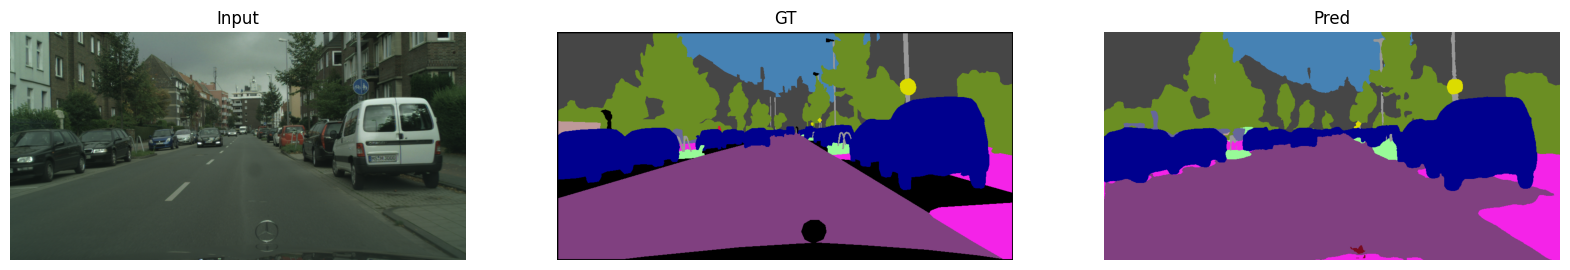

In [4]:
# ============================== CONFIG ==============================
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import autocast, GradScaler
from torchmetrics.classification import MulticlassJaccardIndex
from tqdm import tqdm
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ------------------- COLAB PRO SETTINGS -------------------
!nvidia-smi  # Verifica que tengas A100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ------------------- HYPERPARAMETERS -------------------
IMG_SIZE = (512, 1024)  # Cityscapes original aspect ratio
BATCH_SIZE_TRAIN = 16
BATCH_SIZE_VAL = 8
NUM_WORKERS = 4
EPOCHS = 120
LR = 3e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 15

# ------------------- DATASET PATH (KAGGLE) -------------------
DATA_PATH = "/kaggle/input/cityscape-dataset"

# ------------------- CITYSCAPES MAPPING (19 classes) -------------------
ID_TO_TRAINID = {7:0, 8:1, 11:2, 12:3, 13:4, 17:5, 19:6, 20:7, 21:8, 22:9,
                 23:10, 24:11, 25:12, 26:13, 27:14, 28:15, 31:16, 32:17, 33:18}
IGNORE_INDEX = 255
NUM_CLASSES = 19

# ------------------- TRANSFORMS -------------------
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(height=IMG_SIZE[0], width=IMG_SIZE[1]),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# ------------------- DATASET CLASS -------------------
class CityscapesDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.samples = []
        for city in os.listdir(img_dir):
            city_img = os.path.join(img_dir, city)
            city_mask = os.path.join(mask_dir, city)
            for img_name in os.listdir(city_img):
                if img_name.endswith("_leftImg8bit.png"):
                    mask_name = img_name.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                    img_path = os.path.join(city_img, img_name)
                    mask_path = os.path.join(city_mask, mask_name)
                    if os.path.exists(mask_path):
                        self.samples.append((img_path, mask_path))
        print(f"Found {len(self.samples)} samples")

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Remap to 0-18 + 255
        h, w = mask.shape
        train_mask = np.full((h, w), IGNORE_INDEX, dtype=np.uint8)
        for label_id, train_id in ID_TO_TRAINID.items():
            train_mask[mask == label_id] = train_id

        if self.transform:
            aug = self.transform(image=img, mask=train_mask)
            img, mask = aug['image'], aug['mask'].long()

        return img, mask

# ------------------- DATA LOADERS -------------------
train_dataset = CityscapesDataset(
    img_dir=f"{DATA_PATH}/Cityscape Dataset/leftImg8bit/train",
    mask_dir=f"{DATA_PATH}/Fine Annotations/gtFine/train",
    transform=train_transform
)

val_dataset = CityscapesDataset(
    img_dir=f"{DATA_PATH}/Cityscape Dataset/leftImg8bit/val",
    mask_dir=f"{DATA_PATH}/Fine Annotations/gtFine/val",
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True)

# ------------------- MODEL: PAN (SMP) -------------------
model = smp.PAN(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None,
).to(device)

# ------------------- LOSS & OPTIMIZER -------------------
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = GradScaler()
jaccard = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX, average='macro').to(device)

# ------------------- EARLY STOPPING -------------------
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score, model, path):
        if self.best_score is None or val_score > self.best_score + self.min_delta:
            self.best_score = val_score
            self.counter = 0
            torch.save(model.state_dict(), path)
            print(f"  Model saved! mIoU: {val_score:.4f}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

early_stopping = EarlyStopping(patience=PATIENCE)

# ------------------- UNNORMALIZE -------------------
class UnNormalize:
    def __init__(self, mean, std): self.mean, self.std = mean, std
    def __call__(self, tensor):
        tensor = tensor.clone()
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

# ------------------- TRAINING LOOP -------------------
best_miou = 0.0
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_miou = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            imgs, masks = imgs.to(device), masks.to(device)
            with autocast():
                outputs = model(imgs)
            pred = outputs.argmax(1)
            val_miou += jaccard(pred, masks).item()

    avg_miou = val_miou / len(val_loader)
    print(f"Epoch {epoch+1} | Loss: {train_loss/len(train_loader):.4f} | mIoU: {avg_miou:.4f}")

    # Early stopping
    if early_stopping(avg_miou, model, "best_pan_cityscapes.pth"):
        print("Early stopping!")
        break

# ------------------- VISUALIZATION -------------------
model.load_state_dict(torch.load("best_pan_cityscapes.pth"))
model.eval()
with torch.no_grad():
    img, mask = val_dataset[0]
    pred = model(img.unsqueeze(0).to(device)).argmax(1).cpu().numpy()[0]

    img_np = unorm(img).permute(1, 2, 0).numpy()
    mask_np = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)
    pred_np = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3), dtype=np.uint8)

    colors = [
        [128,64,128],[244,35,232],[70,70,70],[102,102,156],[190,153,153],
        [153,153,153],[250,170,30],[220,220,0],[107,142,35],[152,251,152],
        [70,130,180],[220,20,60],[255,0,0],[0,0,142],[0,0,70],[0,60,100],
        [0,80,100],[0,0,230],[119,11,32]
    ]

    for i, color in enumerate(colors):
        mask_np[mask == i] = color
        pred_np[pred == i] = color

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1); plt.title("Input"); plt.imshow(img_np); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("GT"); plt.imshow(mask_np); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("Pred"); plt.imshow(pred_np); plt.axis('off')
    plt.show()

In [5]:
from google.colab import files
files.download("best_pan_cityscapes.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://grok.com/share/c2hhcmQtMi1jb3B5_78128bda-40c6-4670-9111-ca193b0247d9